CFE Data Assimilation of USGS streamflow data. Synthetic Forcing Data example to test methodology and 1-18 hour forecast. 

In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta

sys.path.insert(0, './CFE')
#import bmi_cfe_originial
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


(750.0, 780.0)

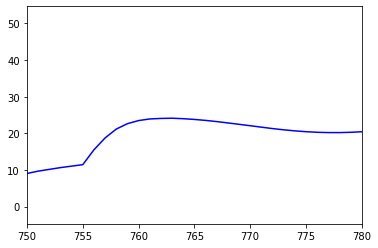

In [2]:
# Get Synthetic Observations (USGS)
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')

# Open forcing file
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
# Make empty list to plot
OBSERVATIONS_LIST = []

# Loop through precipitation in forcing data to set values
for i, precip in enumerate(df_forcing['APCP_surface_0']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    # Get streamflow based on sin wave to see variation in synthetic observed streamflow
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)

cfe_obs.finalize()

# See plot to make sure it works
plt.plot(OBSERVATIONS_LIST,color = 'blue')
plt.xlim(750,780)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

Final Framework for running each synthetic CFE model, EnKF DA, and synthetic observations

In [4]:
#Make empty matrices for plotting
cfeOpen_ensa    = []
cfeAnalysis_ens = []

## Loop through n different precipitation files for forcing. Max is 100 from forcing data
n_loop = 2
for loop in range(n_loop):
    p = 'APCP_surface_' + str(loop) #set p to each synthetic forcing data
    
    # Make empty matrices for plotting
    cfeOpen = []
    cfePeturbed = []
    cfeAnalysis = []
    cfeEnKF = []
    
    # Initialize Case study files
    cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json')
    
    ## Loop through time. Set values for each model and get values
    for i, precip in enumerate(df_forcing[str(p)]):

        # Set values for each CFE model. Adding precipitation since we are using an uncalibrated model to see flow result
        cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3) #value of precip from forcing data in loop
        cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        
        # Update usgs data and get value to put into EnKF
        obs = OBSERVATIONS_LIST[i]
        enkf.set_value('validity', 1)

        # set observations to plot without EnKF for future forecast
        if i>=768:
            enkf.set_value('validity', 0)

        # Update CFE open and peturbed. Get value for peturbed stats. 
        cfe_open.update()
        cfe_peturbed.update()
        
        # Get state variable originial values from CFE Peturbed to update in EnKF
        #soil_storage_avail             = cfe_peturbed.get_value('soil_storage_avail_m')
        soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
        storage_max_m                  = cfe_peturbed.get_value("storage_max_out_m")
        surface_runoff                 = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')

        # Set outflow for CFE Open and CFE Peturbed to plot
        outflow        = cfe_open.get_value('land_surface_water__runoff_depth')
        cfeOpen.append(outflow) #for plotting
        
        # Get mean and covariance of CFE Peturbed outflor of ensemble runs for EnKF
        outflow_peturb       = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
        outflow_peturb_mean  = np.mean(outflow_peturb)
        outflow_peturb_covar = np.cov(outflow_peturb)
        cfePeturbed.append(outflow_peturb_mean) # For plotting

        # Set EnKF state variable values to state variables from CFE Petubred
        #enkf.set_value('soil_storage_avail_m', soil_storage_avail) 
        enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) 
        enkf.set_value('surface_runoff_depth_m', surface_runoff)
        enkf.set_value('storage_max_m',storage_max_m)

        # Set EnkF values usgs, mean, and covariance (from CFE Peturbed)
        enkf.set_value('x', np.array([outflow_peturb_mean]))
        enkf.set_value('P', np.array([outflow_peturb_covar]))
        enkf.set_value('z', np.array([obs]))
        #enkf_validity=enkf.set_value('validity',validity) #check validity if needed
        enkf.update()
        
        # For plotting if needed
        outflow_enkf = enkf.get_value('enkf')
        cfeEnKF.append(outflow_enkf)
        
        # Get updated state variable values from EnKF to pass into CFE Analysis
        #state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
        state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
        # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
        state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

        # Set CFE analysis state variable changes from EnKF to get final true streamflow values
        #cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) 
        cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) 
        cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
        cfe_analysis.update() #get new streamflow value based on state var change
        
        # For plotting CFE Analysis from newly updated state variables. FINAL MODEL! 
        outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
        cfeAnalysis.append(outflow_analysis) 

        # Get CFE Analysis state variables to then pass back into CFE Peturbed 
        #cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
        cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
        cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

        # Set updated state variables into CFE Peturbed for the loop of updating state variables to continue! 
        #cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
        cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
        cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)

    # Append models results from last hour of data assimilation for the 18 hour forecast
    cfeOpen_ensa.append(np.divide(abs(np.subtract(cfeOpen[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    cfeAnalysis_ens.append(np.divide(abs(np.subtract(cfeAnalysis[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    
    # Get mean of each hour in 18hour forecast
    cfeOpen_ensa_mean=np.mean(cfeOpen_ensa,axis=0)
    cfeanalysis_ensa_mean=np.mean(cfeAnalysis_ens,axis=0)
    
# Finalize the models!  
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()



GLOBAL MASS BALANCE
  initial volume:   0.6352
    volume input: 13899.2473
   volume output: 13855.2805
    final volume:   0.8224
        residual: 5.3291e-13

SCHAAKE MASS BALANCE
  surface runoff: 13892.2071
    infiltration:   7.0401
schaake residual: 2.6654e-12

GIUH MASS BALANCE
  vol. into giuh: 13892.2071
   vol. out giuh: 13848.4276
 vol. end giuh q:  43.7795
   giuh residual: 2.6148e-12

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
   init soil vol:   0.6252
  vol. into soil:   7.0401
vol.soil2latflow:   6.4566
 vol. soil to gw:   0.3939
 final vol. soil:   0.8147
vol. soil resid.: 1.1435e-14

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   6.4566
  vol. from nash:   5.9063
 final vol. nash:   0.5503
nash casc resid.: 1.1102e-16

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0100
       vol to gw:   0.3939
     vol from gw:   0.3962
final gw.storage:   0.0077
    gw. residual: -3.9899e-17

GLOBAL MASS BALANCE
  initial volume:   0.63

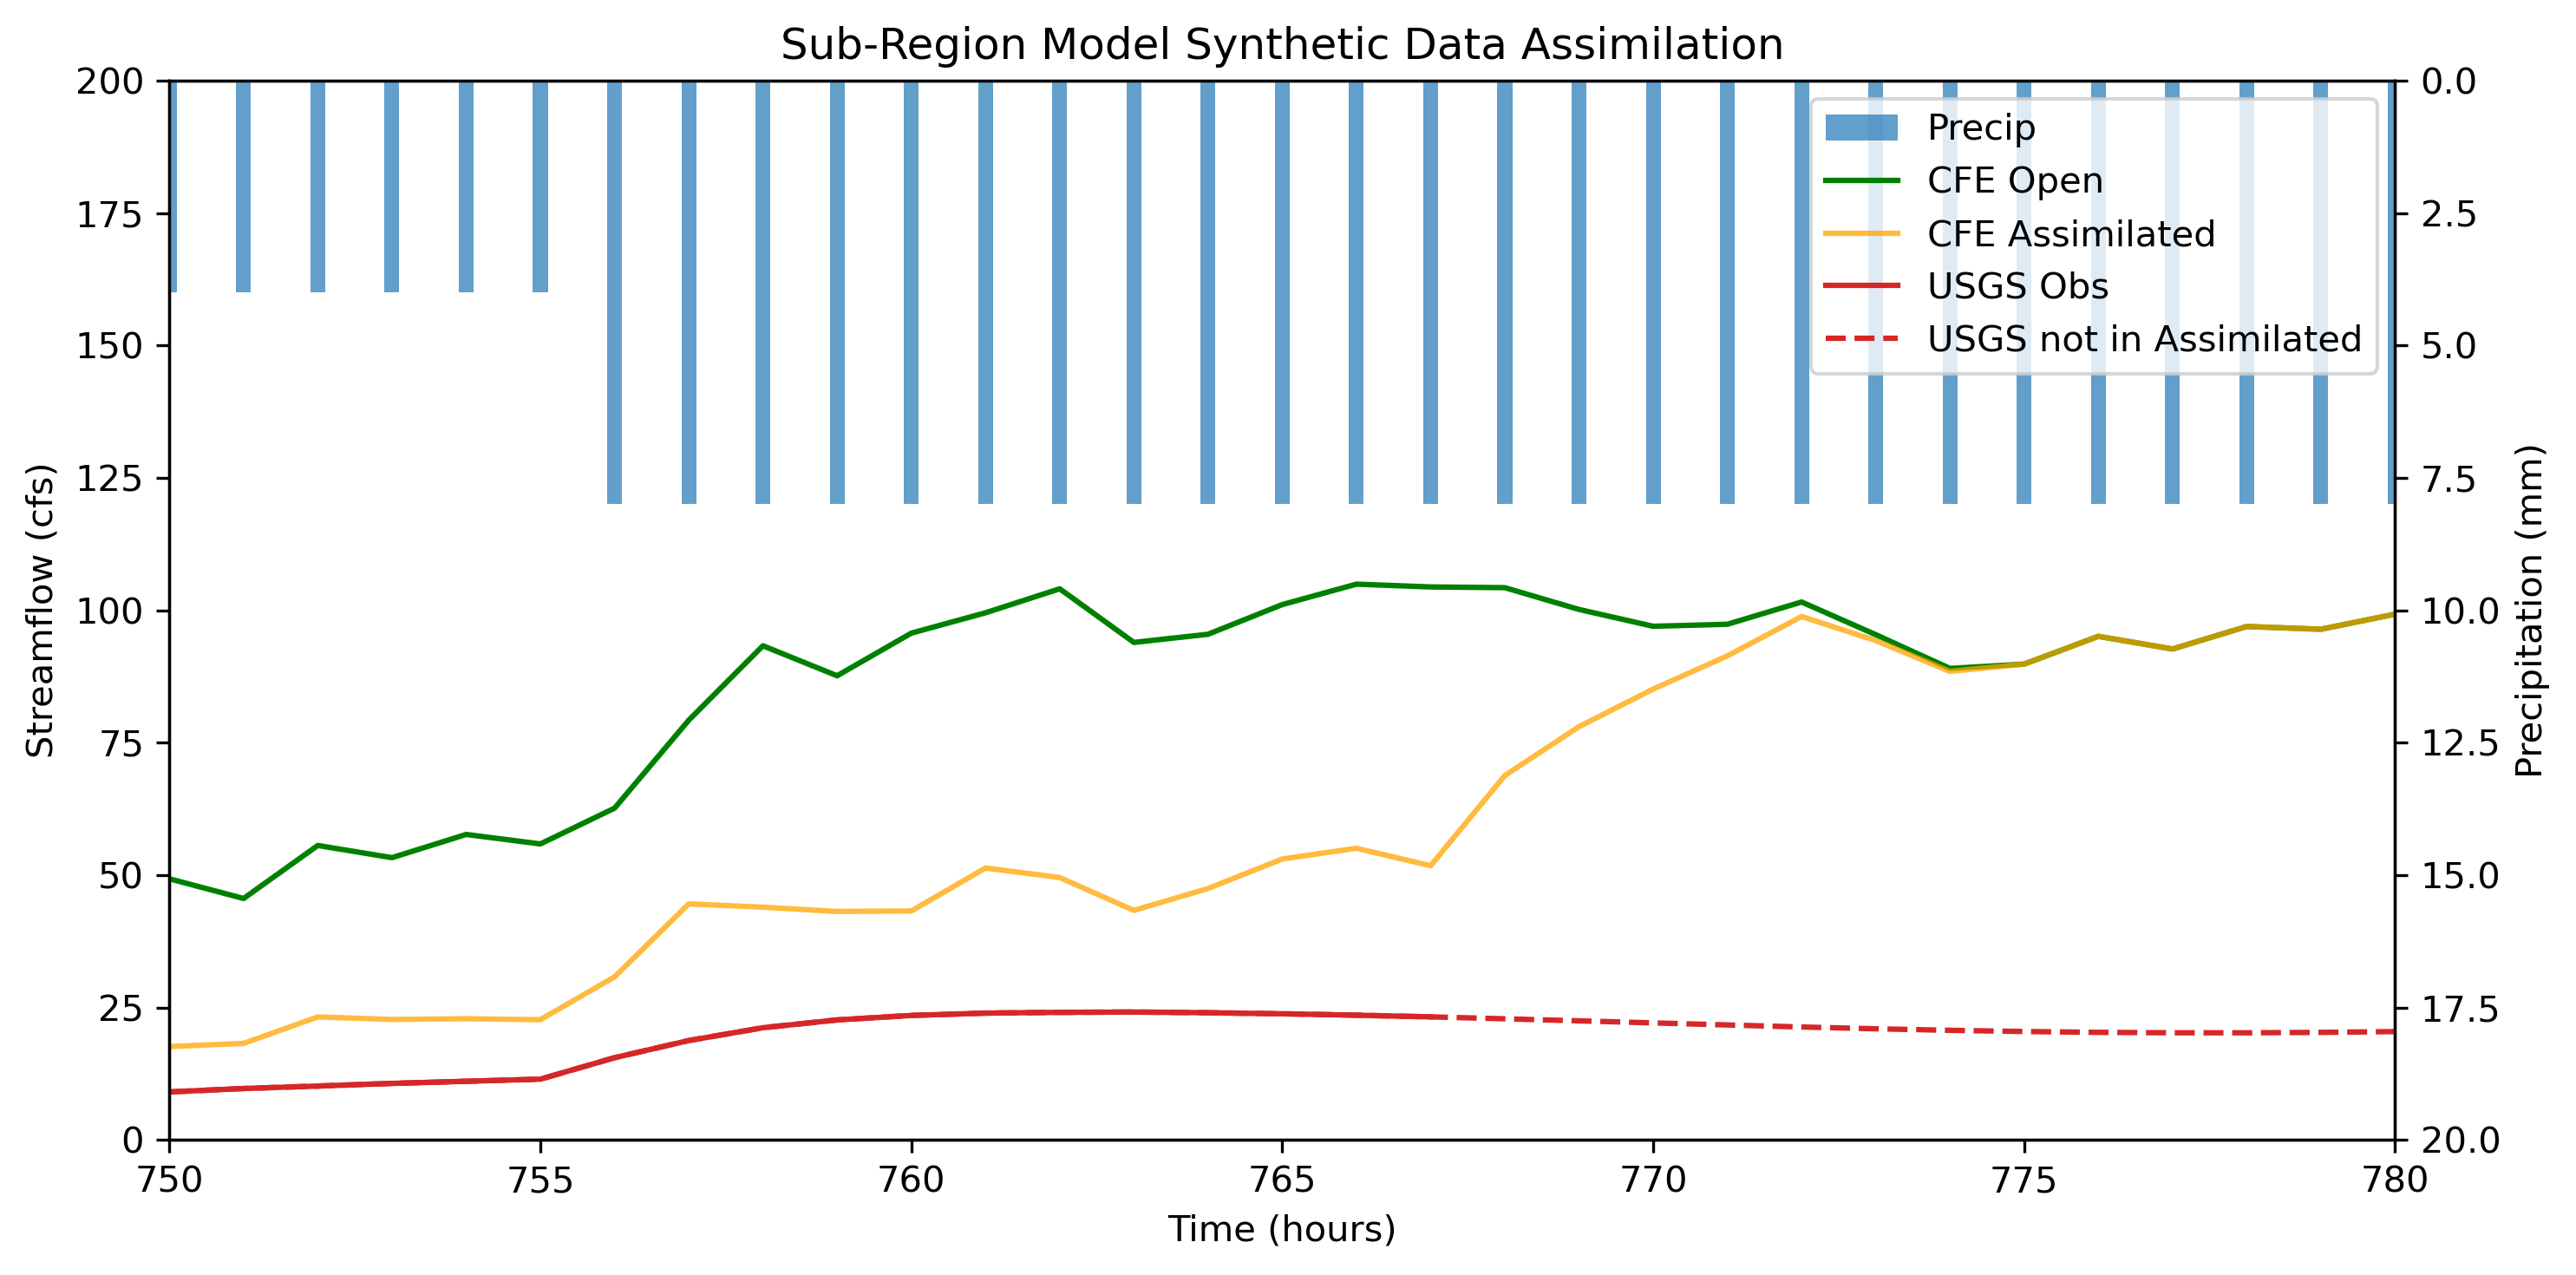

In [5]:
# Define time range for plotting
istart_plot=0
iend_plot=786
x = list(range(istart_plot, iend_plot))

# Set plotting dimensions
fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

# Make double y-axis to plot precipitation on top of of the plot. Set labels and limits for axes
ax2 = ax1.twinx()
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,20,1)
ax2.invert_yaxis()
plt.xlim(750,780)

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Streamflow (cfs)')
ax1.set_ylim(0,200,1)

plt.title('Sub-Region Model Synthetic Data Assimilation')

# Plot the variables on the plot! 
Precip = ax2.bar(x, df_forcing['APCP_surface_0'],width=0.2,alpha=0.7, color="tab:blue", label = 'Precip')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(OBSERVATIONS_LIST[istart_plot:768], color = 'tab:red', label = 'USGS Obs')
Obs2, = ax1.plot(OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS not in Assimilated')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

# Plot the legend and fix layout
plt.legend(handles = [Precip,Open,Analysis,Obs,Obs2], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
fig.tight_layout()
ax1.margins(x=0)

#plt.savefig("WorkingDA_7-19.png")
plt.show()


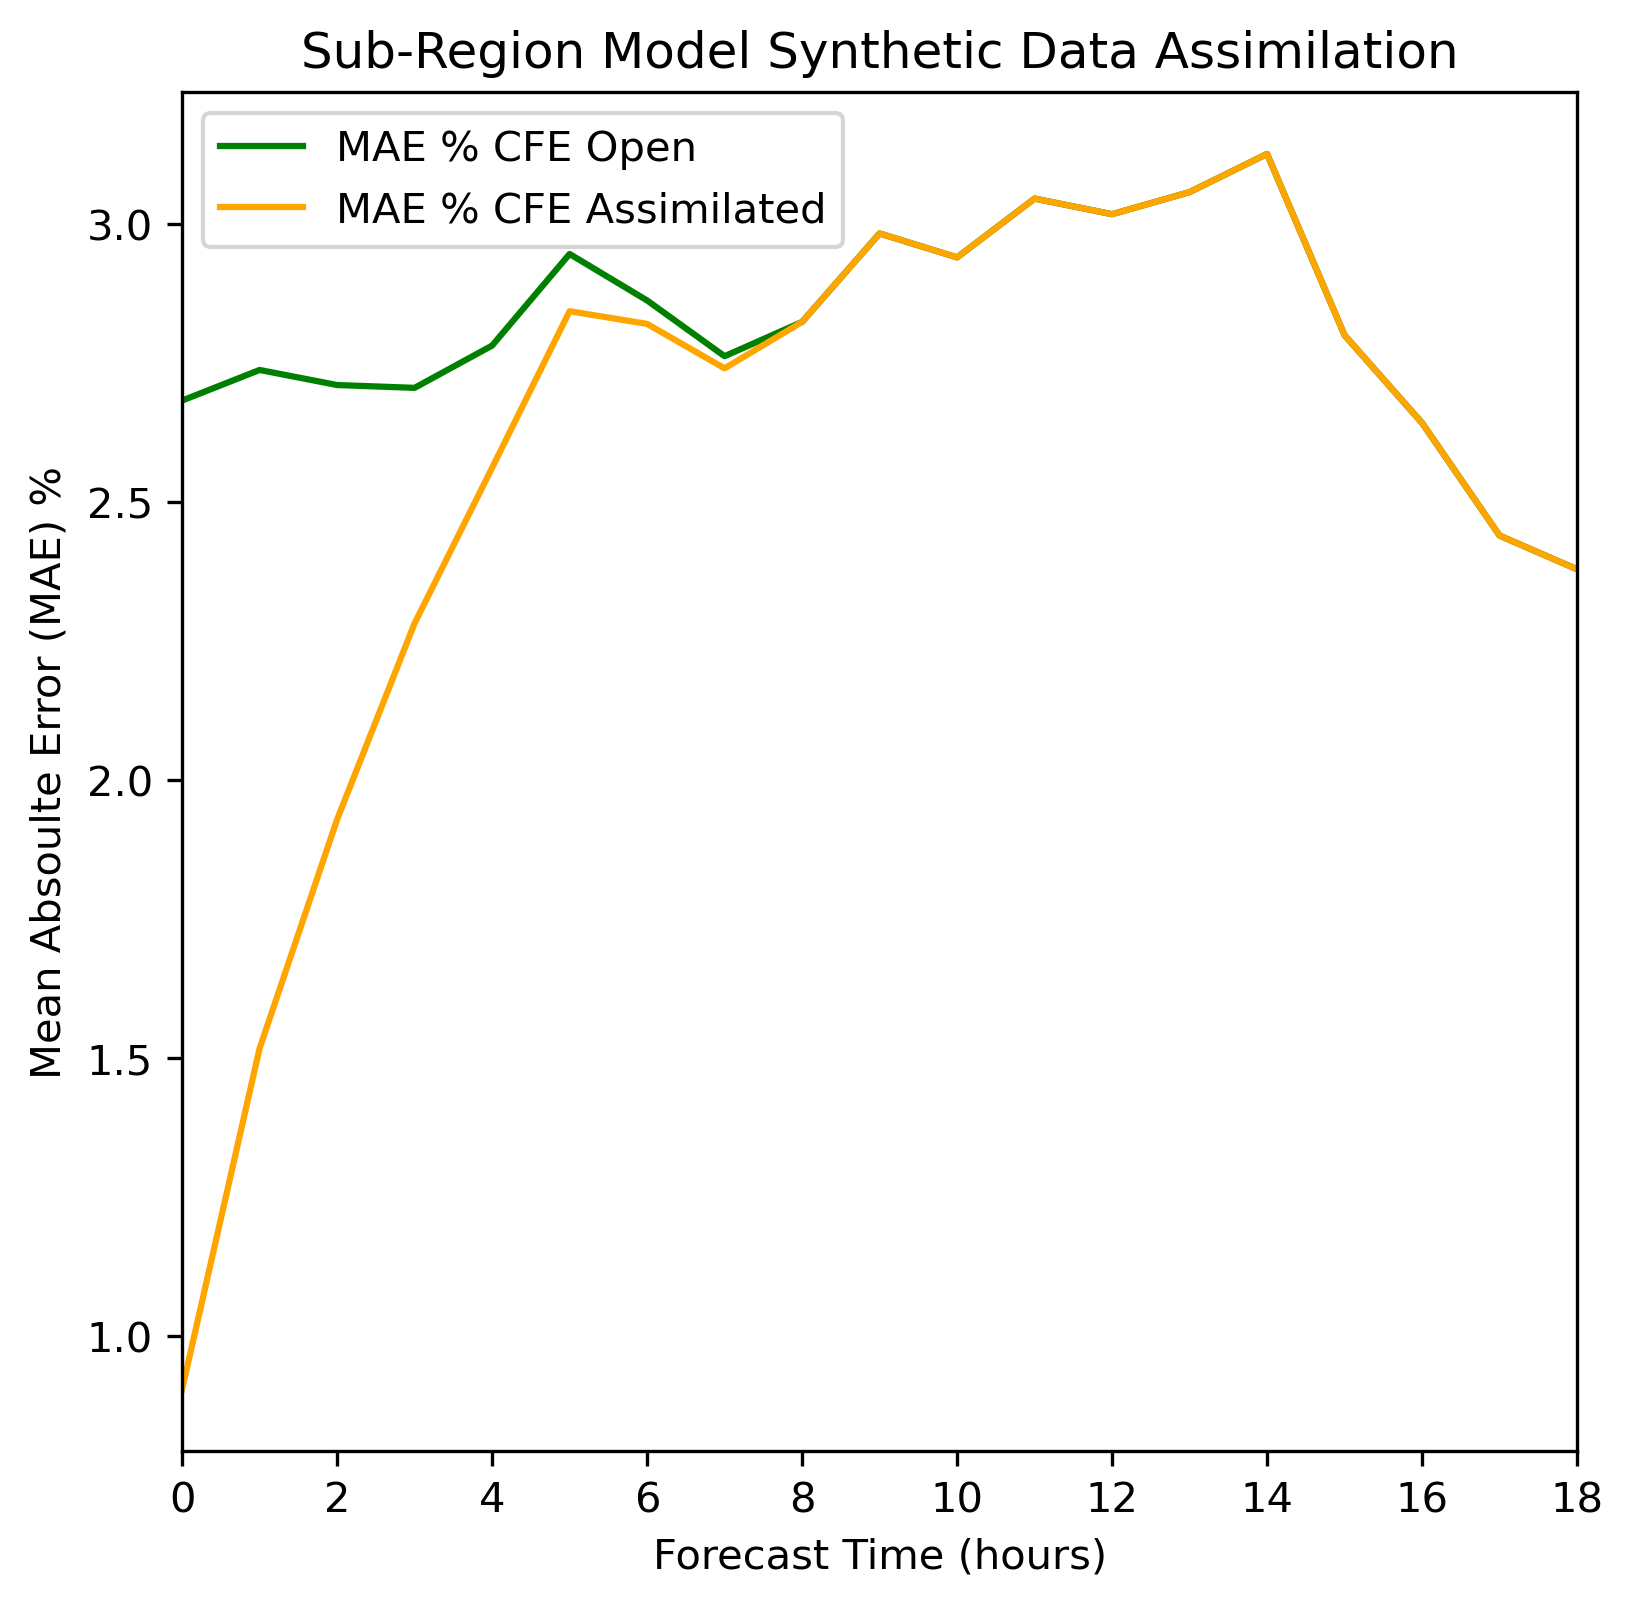

In [6]:
# Plot the Mean Absolute Error (MAE) of CFE Open vs CFE Assimilated
fig = plt.subplots(figsize = (6,6), dpi=300)

# Set labels and limits
plt.title('Sub-Region Model Synthetic Data Assimilation')
plt.xlim(0,18)
plt.xlabel('Forecast Time (hours)')
plt.ylabel('Mean Absoulte Error (MAE) %')

# Plot data
plt.plot(cfeOpen_ensa_mean, color = 'green', label = 'MAE % CFE Open')
plt.plot(cfeanalysis_ensa_mean, color = 'orange', label = 'MAE % CFE Assimilated')

# Show
plt.legend()
plt.show()


In [7]:
# Put values into dataframe to calculate statistics
df = pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True) #drop NaN values
df.reset_index(drop=True, inplace=True) #reset index


# CFE Open Evaluation
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias_open=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("CFE Open Statistics")
print("r_open     =",r_open[0])
print("KGE_open   =",kge_open[0])
print("NSE_open   =", nse_open[0])
print("PBIAS_open =", pbias_open[0])
print("--------------------------")

# CFE Analysis Evaluation
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("CFE Analysis Statistics")
print("r_analysis     =",r_analysis[0])
print("KGE_analysis   =",kge_analysis[0])
print("NSE_analysis   =", nse_analysis[0])
print("PBIAS_analysis =", pbias_analysis[0])
print("--------------------------")

# Mean and Std of Models and Observations
print("Mean and STD of Models and Observations")
print("mean_obs      =",np.mean(df["obs"]))
print("STD_obs       =",np.std(df["obs"]))
print("mean_open     =",np.mean(df["cfeOpen"]))
print("STD_open      =",np.std(df["cfeOpen"]))
print("mean_analysis =",np.mean(df["cfeAnalysis"]))
print("STD_analysis  =",np.std(df["cfeAnalysis"]))

CFE Open Statistics
r_open     = 0.9752711532378185
KGE_open   = -0.0767505289500583
NSE_open   = -0.8777810226868932
PBIAS_open = 84.00853906632571
--------------------------
CFE Analysis Statistics
r_analysis     = 0.8980296052664524
KGE_analysis   = 0.15923036239650756
NSE_analysis   = 0.16068339285513578
PBIAS_analysis = 66.87317732460112
--------------------------
Mean and STD of Models and Observations
mean_obs      = 7.82998928152997
STD_obs       = 11.330467618341043
mean_open     = 48.96356445483878
STD_open      = 34.65822995885161
mean_analysis = 23.63640291812467
STD_analysis  = 22.628935099620094
